In [1]:
from __future__ import division
import os
from ipywidgets import interact
from ipywidgets import widgets
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn.gaussian_process as skg
import sklearn.neighbors as skn
import sklearn.mixture as skm
import glob
import pandas as pd
%matplotlib inline

In [2]:
histogram = np.genfromtxt("../data/set_train_histogram.csv", skip_header=True, delimiter=",")
n = 1000000
histogram[:, 1] /= np.sum(histogram[:, 1])

In [3]:
weights = np.array([0.0620489, 0.722237, 0.215714])
means = np.array([268.8299584, 825.967384, 1339.920449])
sds = np.array([65.4319413, 261.051618, 93.081572])

/home/matteo/.pyenv/versions/2.7.9/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


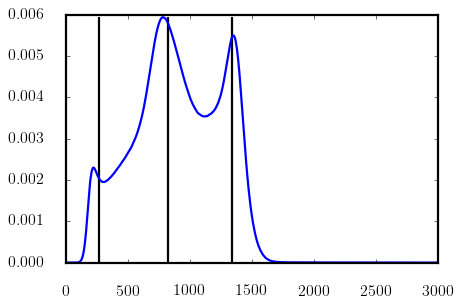

In [4]:
plt.figure()
plt.plot(histogram[:, 0], histogram[:, 1]);
plt.vlines(means, ymin=0, ymax=np.max(histogram[:, 1]))

[   0    1    2 ..., 2997 2998 2999]


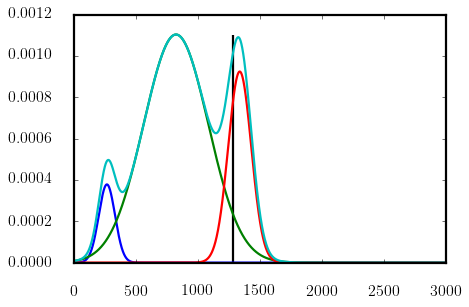

In [5]:
pdfs = [scipy.stats.norm(loc=mean, scale=sd) for mean, sd in zip(means, sds)]

plt.figure()
x = np.arange(0, 3000, 1)
print(x)
plt.plot(x, weights[0]*pdfs[0].pdf(x))
plt.plot(x, weights[1]*pdfs[1].pdf(x))
plt.plot(x, weights[2]*pdfs[2].pdf(x))
plt.plot(x, weights[0]*pdfs[0].pdf(x) + weights[1]*pdfs[1].pdf(x) + weights[2]*pdfs[2].pdf(x))
gm_wm_threshold = x[np.argmax(weights[2]*pdfs[2].pdf(x) / weights[1]*pdfs[1].pdf(x))]
plt.vlines(gm_wm_threshold, ymin=0, ymax=np.max(weights[1] * pdfs[1].pdf(x)))

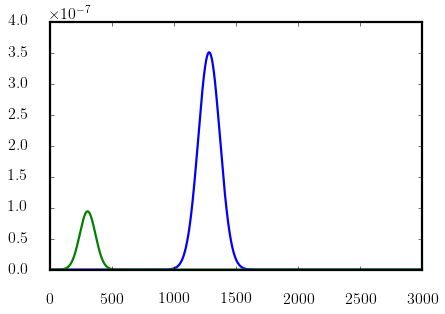

In [6]:
plt.figure()
plt.plot(x, weights[2]*pdfs[2].pdf(x) / weights[1]*pdfs[1].pdf(x))
plt.plot(x, weights[0]*pdfs[0].pdf(x) / weights[1]*pdfs[1].pdf(x))


In [7]:
def show_image(path, x, y, z):
    img = nb.load(path).get_data()[..., 0]
    limits = (0, 2000)
    fig = plt.figure(figsize=(20, 20)) 
    plt.subplot(1, 3, 1)
    plt.imshow(img[:, :, z],
                        cmap=plt.cm.gray,
                        interpolation='none'
                        )
    plt.clim(*limits)
    plt.subplot(1, 3, 2)
    plt.imshow(img[:, y, :],
                        cmap=plt.cm.gray,
                        interpolation='none'
                        )
    plt.clim(*limits)
    plt.subplot(1, 3, 3)
    plt.imshow(img[x, :, :],
                        cmap=plt.cm.gray,
                        interpolation='none'
              )
    plt.clim(*limits)
    segmentation_seed = np.zeros(img.shape, dtype=np.uint8)
    segmentation_seed[img == 0] = 1
    segmentation_seed[np.logical_and(img > 0, img < 300)] = 2
    segmentation_seed[np.logical_and(img > 650, img < 850)] = 3
    segmentation_seed[np.logical_and(img > 1050, img < 1450)] = 4     
    fig = plt.figure(figsize=(20, 20)) 
    plt.subplot(1, 3, 1)
    plt.imshow(np.rot90(segmentation_seed[:, :, z]),
                        cmap=plt.cm.gray,
                        interpolation='none'
                        )
    
    plt.subplot(1, 3, 2)
    plt.imshow(np.rot90(segmentation_seed[:, y, :]),
                        cmap=plt.cm.gray,
                        interpolation='none'
                        )
    plt.subplot(1, 3, 3)
    plt.imshow(np.rot90(segmentation_seed[x, :, :]),
                        cmap=plt.cm.gray,
                        interpolation='none'
              )
    plt.figure()
    plt.hist(img[img > 0].flatten(), bins=256)
    plt.yscale('log', nonposy='clip')

<function __main__.show_image>

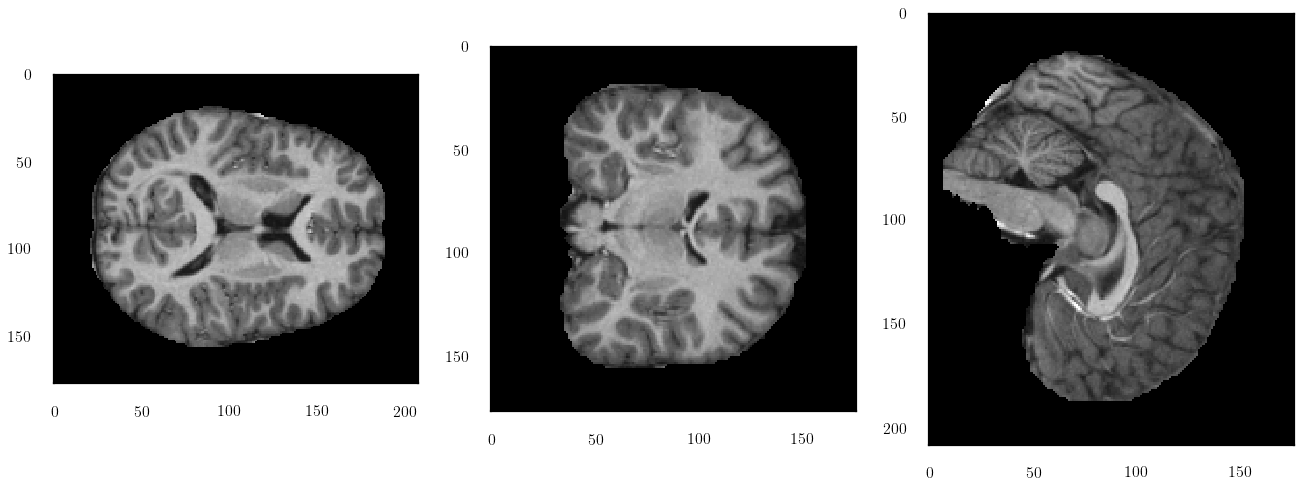

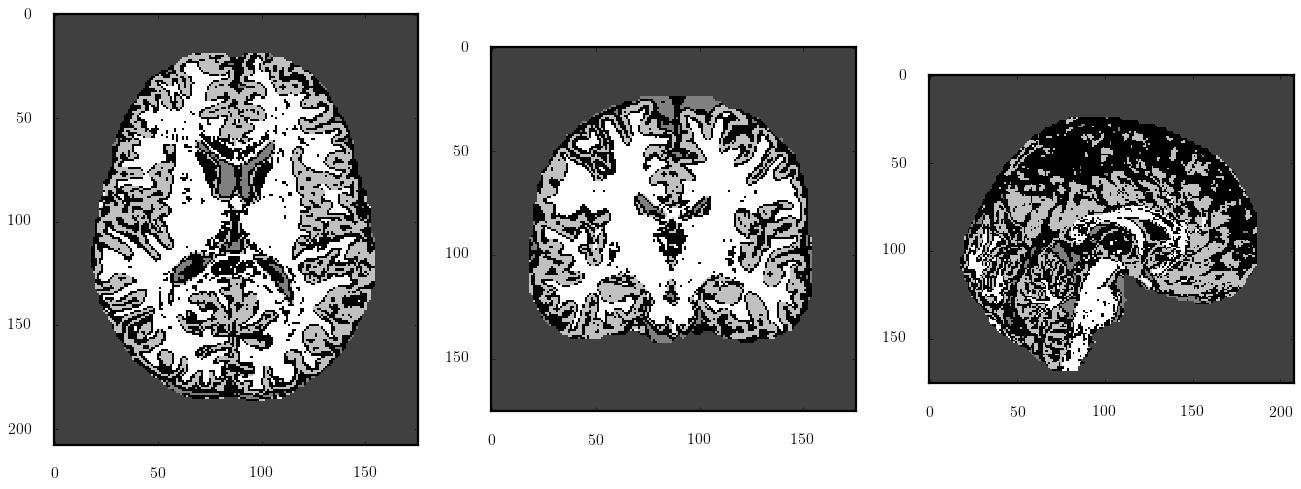

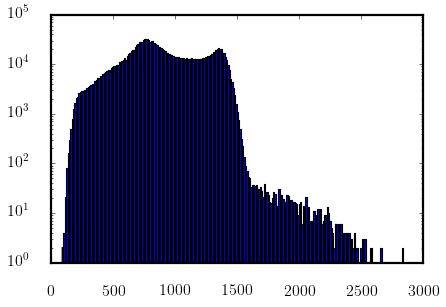

In [8]:
shape = (176, 208, 176)
path = widgets.Text("../data/set_train/train_1.nii")
interact(
    show_image,
    path=path,
    x=widgets.IntSlider(min=0, max=shape[0] - 1, step=1, value=shape[0] // 2),
    y=widgets.IntSlider(min=0, max=shape[1] - 1, step=1, value=shape[1] // 2),
    z=widgets.IntSlider(min=0, max=shape[2] - 1, step=1, value=shape[2] // 2),
)

('Correlation:', 0.02714096551566925)
200.0


<function __main__.get_voxel>

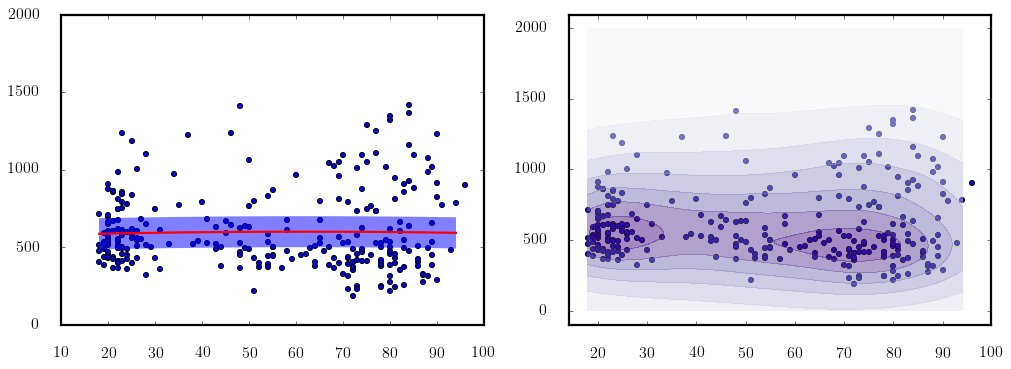

In [9]:
file_names = glob.glob("../data/set_train/train_*.nii")
def get_voxel(x, y, z):
    age_id = np.genfromtxt("../data/targets.csv")
    voxels = np.zeros(shape=len(file_names), dtype=np.int16)
    ages = np.zeros(shape=len(file_names), dtype=np.int16)
    for j, file_name in enumerate(file_names):
        index = int(os.path.splitext(os.path.basename(file_name))[0].split("_")[1]) - 1
        voxel = nb.load(file_name).dataobj[x, y, z]
        voxels[j] = voxel
        ages[j] = age_id[index]
        
    kernel = (
        skg.kernels.ConstantKernel(constant_value=500, constant_value_bounds=(100, 2000))
        * skg.kernels.RBF(length_scale=5, length_scale_bounds=(3, 200))
        + skg.kernels.WhiteKernel(noise_level=1000, noise_level_bounds=(1e3, 1e4))
    )
    
    corr = np.abs(np.corrcoef(ages, voxels)[0, 1])
    print("Correlation:", corr)
    gp = skg.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    gp.fit(ages.reshape(-1, 1), voxels)
    x = np.arange(18, 95).reshape(-1, 1)
    y_pred, sigma = gp.predict(x, return_std=True)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(ages, voxels)
    plt.plot(x, y_pred, color="r")
    plt.fill(
        np.concatenate([x, x[::-1]]),
        np.concatenate([y_pred - sigma,
                        (y_pred + sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='1sigma confidence interval')
    plt.ylim(0, 2000)
    print(gp.kernel_.get_params()["k1__k2__length_scale"])
    
    scaling_factor = 15
    bidimensional = np.array(zip(ages, voxels / scaling_factor))
    bandwidth = 15
    kde = skn.KernelDensity(kernel="exponential", bandwidth=bandwidth)
    kde.fit(bidimensional)
    x = np.arange(18, 95)
    y = np.arange(0, 2000 / scaling_factor)
    xx, yy = np.meshgrid(x, y)
    xy = np.dstack((xx, yy)).reshape(-1, 2)
    z = np.exp(kde.score_samples(xy))
    
    plt.subplot(1, 2, 2)
    plt.scatter(ages, voxels)
    plt.contourf(xx, yy * scaling_factor, z.reshape(xx.shape), cmap="Purples", alpha=0.5)

    
interact(
    get_voxel,
    x=widgets.IntSlider(min=0, max=shape[0] - 1, step=1, value=shape[0] // 2),
    y=widgets.IntSlider(min=0, max=shape[1] - 1, step=1, value=shape[1] // 2),
    z=widgets.IntSlider(min=0, max=shape[2] - 1, step=1, value=shape[2] // 2),
    )

('Correlation:', 0.02714096551566925)
200.0
('Correlation:', 0.37155967562378522)
84.0505627206
('Correlation:', 0.75249754417280657)
38.7621542252


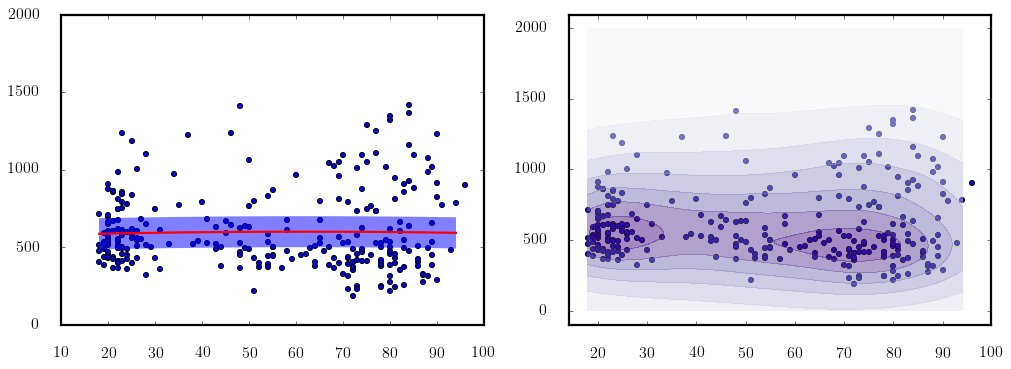

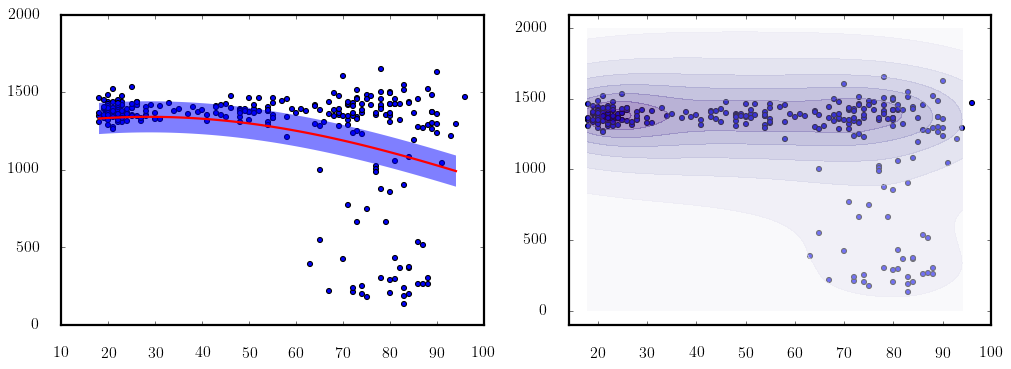

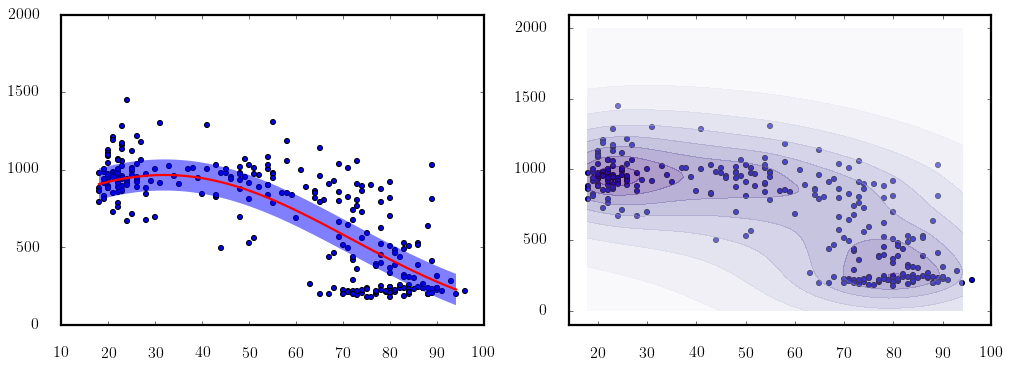

In [10]:
get_voxel(88, 104, 88);
get_voxel(107, 76, 100);
get_voxel(98, 121, 88);

# Probability distribution

<function __main__.probability_density>

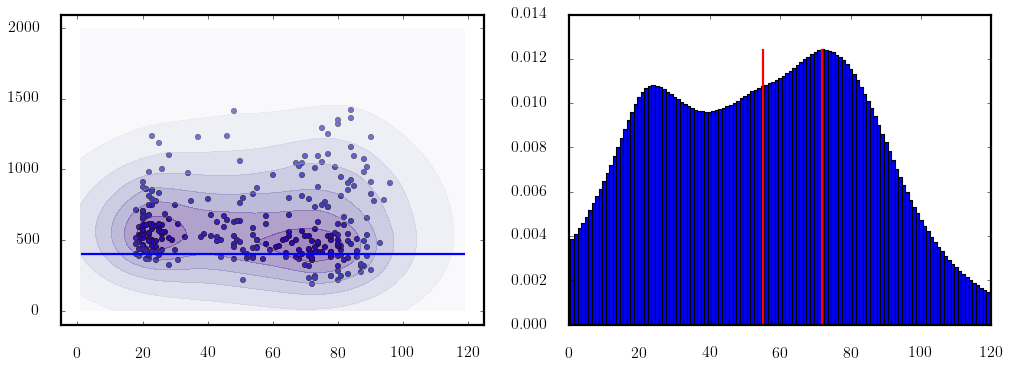

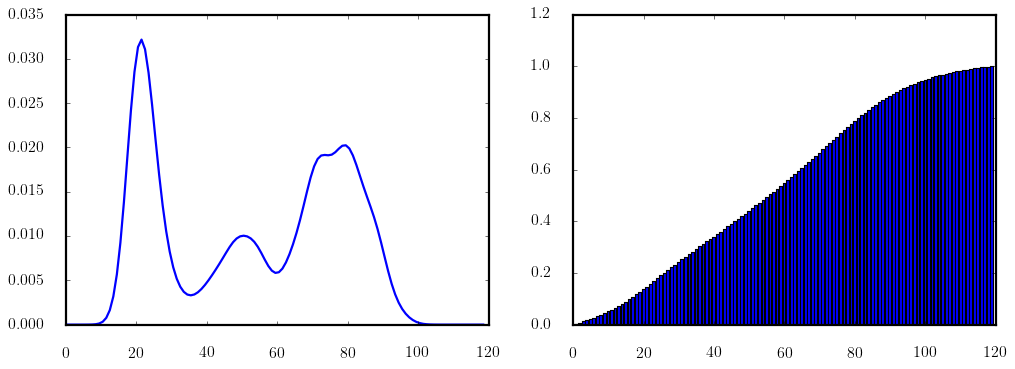

In [11]:
def probability_density(x, y, z, value):
    age_id = np.genfromtxt("../data/targets.csv")
    voxels = np.zeros(shape=len(file_names), dtype=np.int16)
    ages = np.zeros(shape=len(file_names), dtype=np.int16)
    for j, file_name in enumerate(file_names):
        index = int(os.path.splitext(os.path.basename(file_name))[0].split("_")[1]) - 1
        voxel = nb.load(file_name).dataobj[x, y, z]
        voxels[j] = voxel
        ages[j] = age_id[index]
    
    scaling_factor = 15        
    bidimensional = np.array(zip(ages, voxels / scaling_factor))
    bandwidth = 15
    kde = skn.KernelDensity(kernel="exponential", bandwidth=bandwidth)
    kde.fit(bidimensional)
    x = np.arange(1, 120)
    y = np.arange(0, 2000 / scaling_factor)
    xx, yy = np.meshgrid(x, y)
    xy = np.dstack((xx, yy)).reshape(-1, 2)
    z = np.exp(kde.score_samples(xy))
    
    value = value / scaling_factor
    xy = np.vstack((x, np.tile(value, x.shape[0]))).T
    histogram = np.exp(kde.score_samples(xy))
    ages_kde = skn.KernelDensity(kernel="gaussian", bandwidth=3)
    ages_kde.fit(ages.reshape(-1, 1))
    prior = np.exp(ages_kde.score_samples(x.reshape(-1, 1)))
    prior /= np.sum(prior)
    histogram /= np.sum(histogram)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(ages, voxels)
    plt.contourf(xx, yy * scaling_factor, z.reshape(xx.shape), cmap="Purples", alpha=0.5)
    plt.hlines(value * scaling_factor, x[0], x[-1], color="blue")
    plt.subplot(1, 2, 2)
    plt.bar(x - 0.5, histogram, width=1)
    average_age = np.dot(x, histogram)
    mode_age = x[np.argmax(histogram)]
    plt.vlines((average_age, mode_age), 0, np.max(histogram), color="red")
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x - 0.5, prior)
    cumulative = np.cumsum(histogram)
    plt.subplot(1, 2, 2)
    plt.bar(x - 0.5, cumulative)


    
interact(
    probability_density,
    x=widgets.IntSlider(min=0, max=shape[0] - 1, step=1, value=shape[0] // 2),
    y=widgets.IntSlider(min=0, max=shape[1] - 1, step=1, value=shape[1] // 2),
    z=widgets.IntSlider(min=0, max=shape[2] - 1, step=1, value=shape[2] // 2),
    value=widgets.IntSlider(min=0, max=2000, step=10, value=400),
    )

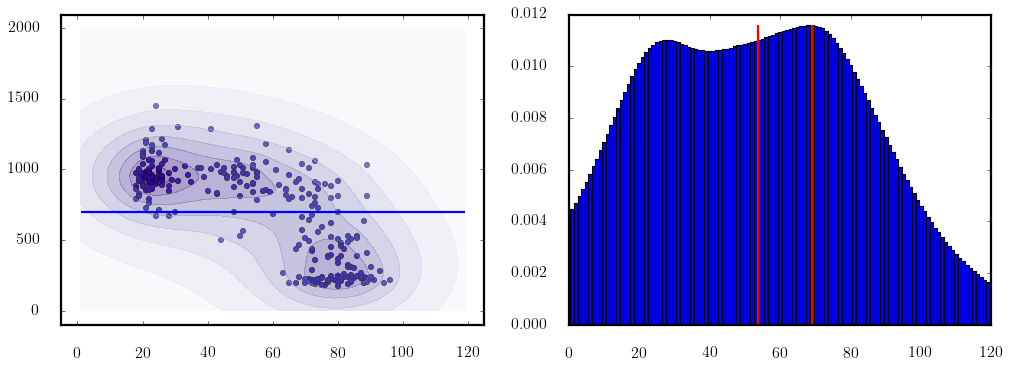

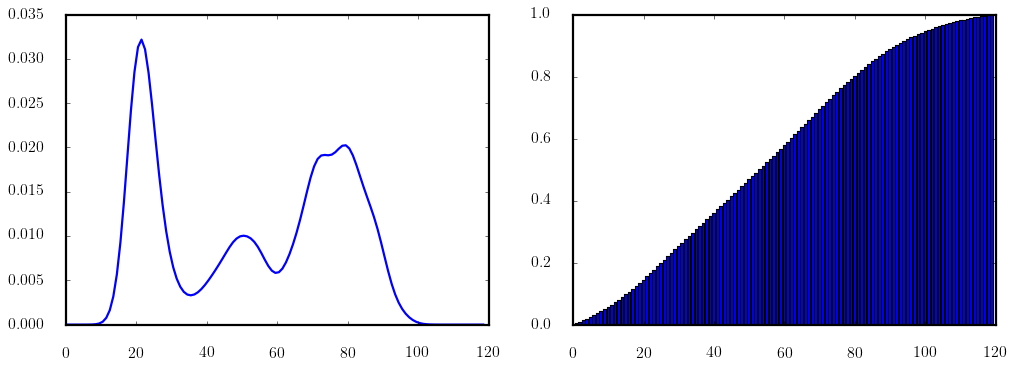

In [12]:
probability_density(98, 121, 88, 700);

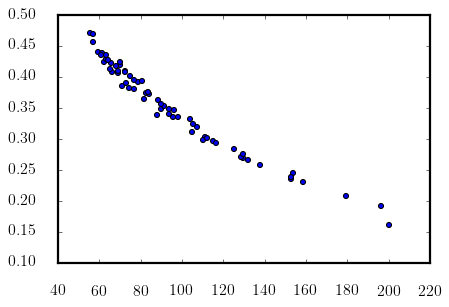

In [13]:
a = np.genfromtxt("table.csv")
plt.figure()
plt.scatter(a[:, 1], a[:, 2])

# Age/voxel correlation

In [14]:
corr_files = glob.glob("../output/correlation_output/*")
corr_data_frame = pd.concat([pd.read_csv(corr_file, header=None) for corr_file in corr_files])
corr_data_frame.sort_values(by=0, inplace=True)
correlation_brain = np.zeros(shape=shape[0] * shape[1] * shape[2], dtype=float)
for row in corr_data_frame.itertuples():
    correlation_brain[row[1]] = row[2]

44816


<function __main__.show_correlation>

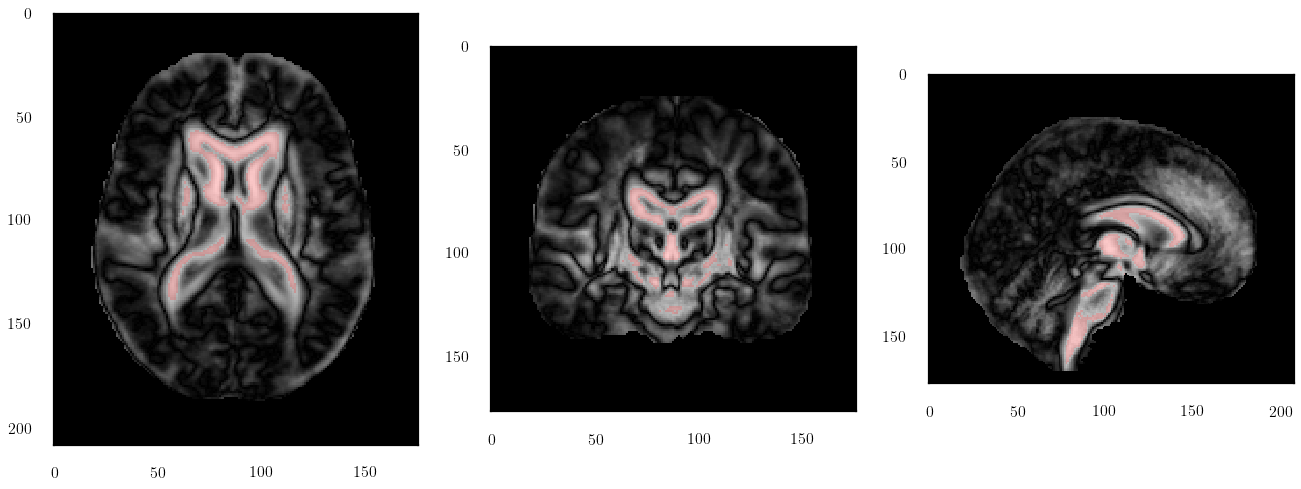

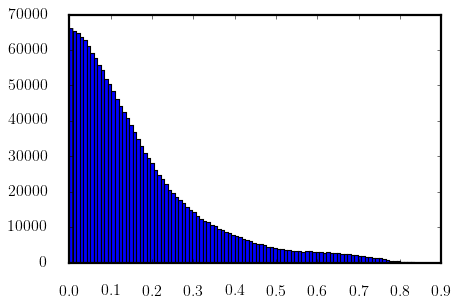

In [16]:
cdict = {
    "red": [(0, 0, 0), (1, 1, 1)],
    "green": [(0, 0, 0), (1, 0, 0)],
    "blue": [(0, 0, 0), (1, 0, 0)],
    "alpha": [(0, 0, 0), (1, 1, 1)],
}
plt.register_cmap(name='RedAlpha', data=cdict)

def show_correlation(x, y, z):
    correlation_threshold = 0.6
    img = np.reshape(correlation_brain, shape)
    img_binary = np.zeros_like(img)
    img_binary[img > correlation_threshold] = 1
    fig = plt.figure(figsize=(20, 20)) 
    plt.subplot(1, 3, 1)
    limits = 0, 1
    plt.imshow(np.rot90(img[:, :, z]),
                        cmap=plt.cm.gray,
                        interpolation='none'
                        )
    plt.imshow(np.rot90(
            img_binary[:, :, z]),
            cmap="RedAlpha",
            interpolation='none',
            alpha=0.2,
            )
    plt.clim(*limits)
    plt.subplot(1, 3, 2)
    plt.imshow(np.rot90(img[:, y, :]),
                        cmap=plt.cm.gray,
                        interpolation='none'
                        )
    plt.imshow(np.rot90(
            img_binary[:, y, :]),
            cmap="RedAlpha",
            interpolation='none',
            alpha=0.2,
            )
    plt.clim(*limits)
    plt.subplot(1, 3, 3)
    plt.imshow(np.rot90(img[x, :, :]),
                        cmap=plt.cm.gray,
                        interpolation='none'
              )
    plt.imshow(np.rot90(
            img_binary[x, :, :]),
            cmap="RedAlpha",
            interpolation='none',
            alpha=0.2,
            )
    plt.clim(*limits)
    
    plt.figure()
    plt.hist(correlation_brain[correlation_brain > 0], bins=100)
    print(np.size(correlation_brain[correlation_brain > correlation_threshold]))
    
interact(
    show_correlation,
    x=widgets.IntSlider(min=0, max=shape[0] - 1, step=1, value=shape[0] // 2),
    y=widgets.IntSlider(min=0, max=shape[1] - 1, step=1, value=shape[1] // 2),
    z=widgets.IntSlider(min=0, max=shape[2] - 1, step=1, value=shape[2] // 2),
    )